In [1]:
import numpy as np
import pandas as pd
import glob

import tensorflow as tf
import tensorflow_datasets as tfds

from bs4 import BeautifulSoup

# (Optional) GPU Setup

In [2]:
######## GPU CONFIGS FOR RTX 2070 ###############
## Please ignore if not training on GPU       ##
## this is important for running CuDNN on GPU ##

tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################

1 Physical GPUs, 1 Logical GPU


# Download Data

In [3]:
# Download file
# !wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# expand archive
# !tar xvzf aclImdb_v1.tar.gz

# Pre-Process Data into DataFrames

In [4]:
def load_reviews(path, columns=["filename", 'review']):
    assert len(columns) == 2
    l = list()
    for filename in glob.glob(path):
        # print(filename)
        with open(filename, 'r') as f:
            review = f.read()
            l.append((filename, review))
    return pd.DataFrame(l, columns=columns)

## Load Unsupervised Data

In [5]:
unsup_df = load_reviews("./aclImdb/train/unsup/*.txt")

In [6]:
unsup_df.describe()

,filename,review
count,50000,50000
unique,50000,49507
top,./aclImdb/train/unsup/26472_0.txt,"Am not from America, I usually watch this show..."
freq,1,5


## Load Training Set

In [7]:
def load_labelled_data(path, neg='/neg/', 
                       pos='/pos/', shuffle=True):
    neg_df = load_reviews(path + neg + "*.txt")
    pos_df = load_reviews(path + pos + "*.txt")
    neg_df['sentiment'] = 0
    pos_df['sentiment'] = 1
    df = pd.concat([neg_df, pos_df], axis=0)
    if shuffle:
        df = df.sample(frac=1, random_state=42)
    return df

In [8]:
train_df = load_labelled_data("./aclImdb/train/")

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 6868 to 11154
Data columns (total 3 columns):
filename     25000 non-null object
review       25000 non-null object
sentiment    25000 non-null int64
dtypes: int64(1), object(2)
memory usage: 781.2+ KB


In [10]:
train_df.head()

,filename,review,sentiment
6868,./aclImdb/train//neg/6326_4.txt,If you're in the mood for some dopey light ent...,0
11516,./aclImdb/train//pos/11177_8.txt,*****Spoilers herein*****<br /><br />What real...,1
9668,./aclImdb/train//neg/2172_2.txt,"Bottom of the barrel, unimaginative, and pract...",0
1140,./aclImdb/train//pos/2065_7.txt,Fearful Symmetry is a pleasant episode with a ...,1
1518,./aclImdb/train//pos/7147_10.txt,I found the storyline in this movie to be very...,1


In [11]:
def fn_to_score(f):
    scr = f.split("/")[-1]  # get file name
    scr = scr.split(".")[0] # remove extension
    scr = int(scr.split("_")[-1]) #the score
    return scr

In [12]:
train_df['score'] = train_df.filename.apply(fn_to_score)

In [13]:
train_df.head()

,filename,review,sentiment,score
6868,./aclImdb/train//neg/6326_4.txt,If you're in the mood for some dopey light ent...,0,4
11516,./aclImdb/train//pos/11177_8.txt,*****Spoilers herein*****<br /><br />What real...,1,8
9668,./aclImdb/train//neg/2172_2.txt,"Bottom of the barrel, unimaginative, and pract...",0,2
1140,./aclImdb/train//pos/2065_7.txt,Fearful Symmetry is a pleasant episode with a ...,1,7
1518,./aclImdb/train//pos/7147_10.txt,I found the storyline in this movie to be very...,1,10


In [14]:
train_df.groupby('score', group_keys=False).\
    apply(lambda x: x.sample(min(len(x), 2), random_state=42))

,filename,review,sentiment,score
5737,./aclImdb/train//neg/12409_1.txt,And that comes from someone that will withstan...,0,1
3779,./aclImdb/train//neg/10918_1.txt,Manmohan Desai made some entertaining though i...,0,1
8225,./aclImdb/train//neg/5132_2.txt,I found out about this film because Jewish Ben...,0,2
7673,./aclImdb/train//neg/2016_2.txt,*****Warning: May contain SPOILERS********* My...,0,2
11432,./aclImdb/train//neg/11945_3.txt,People love the original story for its ending....,0,3
8517,./aclImdb/train//neg/9635_3.txt,WOW! Pretty terrible stuff. The Richard Burton...,0,3
4427,./aclImdb/train//neg/6560_4.txt,"""Shadrach"" was not my favorite type of movie. ...",0,4
9791,./aclImdb/train//neg/8351_4.txt,"Quite average even by Monogram standards, this...",0,4
3025,./aclImdb/train//pos/10654_7.txt,The Haunting is a film that boasts a really cr...,1,7
3381,./aclImdb/train//pos/5642_7.txt,(SPOILERS IN FIRST PARAGRAPH) This movie's ant...,1,7


## Load Testing Set

In [15]:
test_df = load_labelled_data("./aclImdb/test/")

In [16]:
test_df.head()

,filename,review,sentiment
6868,./aclImdb/test//neg/5527_4.txt,"The problem with making a movie like this, tho...",0
11516,./aclImdb/test//pos/2126_9.txt,I feel that this movie is different from so ma...,1
9668,./aclImdb/test//neg/176_3.txt,The filmmakers try to paint the influence of t...,0
1140,./aclImdb/test//pos/4748_8.txt,I recently got THE SEVEN-UPS on video and I mu...,1
1518,./aclImdb/test//pos/11170_10.txt,This movie is a real thriller! It was exciting...,1


In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 6868 to 11154
Data columns (total 3 columns):
filename     25000 non-null object
review       25000 non-null object
sentiment    25000 non-null int64
dtypes: int64(1), object(2)
memory usage: 781.2+ KB


In [18]:
test_df.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


# Create a Tokenizer

In [58]:
# we need to combine both training and unsupervised datasets
# while creating the subword tokenizer
text = unsup_df.review.to_list() + train_df.review.to_list()

In [59]:
len(text)

75000

In [60]:
text[:3]

["Plague doctors, the physicians who treated the sick during the Great Plague of London, wore wide-brimmed black hats, long black overcoats and primitive gas masks in the shape of a bird's beak; in short, they looked bloody freaky.<br /><br />Horror newcomer Curtis Radclyffe attempts to capitalise on the unsettling nature of these bizarre historical figures by making them the antagonists in his film The Sick House, but fails to realise that having a cool looking killer just isn't enough on its own: a coherent plot, decent acting, competent editing and considered direction doesn't go amiss either.<br /><br />After a thoroughly confusing pre-credits sequence featuring a whispering child, Radclyffe's film begins proper with the discovery of a sealed chamber beneath a 17th century hospital. Archaeologist Anna (Gina Philips) is keen to find out what is on the inside, but when the site is declared to be a bio-hazard, she is prevented from continuing her dig. So what does this supposedly inte

In [63]:
txt = [ BeautifulSoup(x).text for x in text ]

In [64]:
txt[:3]

["Plague doctors, the physicians who treated the sick during the Great Plague of London, wore wide-brimmed black hats, long black overcoats and primitive gas masks in the shape of a bird's beak; in short, they looked bloody freaky.Horror newcomer Curtis Radclyffe attempts to capitalise on the unsettling nature of these bizarre historical figures by making them the antagonists in his film The Sick House, but fails to realise that having a cool looking killer just isn't enough on its own: a coherent plot, decent acting, competent editing and considered direction doesn't go amiss either.After a thoroughly confusing pre-credits sequence featuring a whispering child, Radclyffe's film begins proper with the discovery of a sealed chamber beneath a 17th century hospital. Archaeologist Anna (Gina Philips) is keen to find out what is on the inside, but when the site is declared to be a bio-hazard, she is prevented from continuing her dig. So what does this supposedly intelligent scientist do nex

In [65]:
# 8K vocab size
encoder = tfds.features.text.SubwordTextEncoder.\
                build_from_corpus(txt, 
                                  target_vocab_size=2**13)

In [67]:
encoder.save_to_file("imdb")

# Tokenize and Vectorize Data

In [19]:
# load encoder
imdb_encoder = tfds.features.text.SubwordTextEncoder.\
                load_from_file("imdb")

In [20]:
imdb_encoder.vocab_size

8266

## Process Training Dataset

In [21]:
# remove markup
cleaned_reviews = train_df.review.apply(lambda x: BeautifulSoup(x).text)

In [22]:
# convert pandas DF in to tf.Dataset
train = tf.data.Dataset.from_tensor_slices((cleaned_reviews.values, 
                                            train_df.sentiment.values))

In [23]:
for review, senti in train.take(2):
    print(review.numpy(), senti.numpy())

b"If you're in the mood for some dopey light entertainment, this will pass the time. If you expect one jot of plausibility, don't bother. To me, the dance scene looked like it was exaggerated for comic effect; it didn't look especially hot or skilled." 0
b'*****Spoilers herein*****What really scares you? Killer sharks, or maybe ghosts trying to bring back a message? Maybe a chainsaw wielding psychopath?Maybe. But those fears don\'t even compare to a horror which people dare not even speak of or consider--and that is the death of one\'s own child. "Pet Sematary" taps this base, primal adult fear, and then takes it to places that most could not bear to explore.I\'ve read comments about this film that include poor acting, characters making stupid decisions, etc. I disagree. The acting is actually first rate for a film like this. Maybe it is impossible for many to imagine the desperation resulting from such a scenario. But the film\'s events are not only logical, they may be absolutely ine

In [24]:
# transformation functions to be used with the dataset
from tensorflow.keras.preprocessing import sequence

def encode_pad_transform(sample):
    encoded = imdb_encoder.encode(sample.numpy())
    pad = sequence.pad_sequences([encoded], padding='post', 
                                 maxlen=150)
    return np.array(pad[0], dtype=np.int64)  


def encode_tf_fn(sample, label):
    encoded = tf.py_function(encode_pad_transform, 
                                       inp=[sample], 
                                       Tout=(tf.int64))
    encoded.set_shape([None])
    label.set_shape([])
    return encoded, label

In [25]:
# test the transformation on a small subset
subset = train.take(10)
tst = subset.map(encode_tf_fn)

In [26]:
for review, label in tst.take(1):
    print(review.numpy(), label.numpy())
    print(imdb_encoder.decode(review))

[ 152  147 8049  175   10    1 3654   20   58  411 1484   46 1076 3065
    2   13   92 3464    1  161    3  152   32  843   41 1950   18    6
 2456 2397 5250  898    2  100 8049   18 3307  154    3  536  214    2
    1 2294  204  821   48   14   15 6761   34   20 1224 5416  135   14
  192 8049   18  227  343 2198   45 2970   93 8056    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0] 0
If you're in the mood for some dopey light entertainment, this will pass the time. If you expect one jot of plausibility, don't bother. To me, the dance scene looked like it was exaggerated for comic effect; it didn't look especially ho

In [27]:
encoded_train = train.map(encode_tf_fn,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)

## Process Testing Dataset

In [94]:
# remove markup
cleaned_reviews = test_df.review.apply(lambda x: BeautifulSoup(x).text)

In [95]:
# convert pandas DF in to tf.Dataset
test = tf.data.Dataset.from_tensor_slices((cleaned_reviews.values, 
                                            test_df.sentiment.values))

In [96]:
encoded_test = test.map(encode_tf_fn,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Baseline model

In [73]:
# Length of the vocabulary 
vocab_size = imdb_encoder.vocab_size 

# Number of RNN units
rnn_units = 64

# Embedding size
embedding_dim = 64

#batch size
BATCH_SIZE=100

In [72]:
from tensorflow.keras.layers import Embedding, LSTM, \
                                    Bidirectional, Dense,\
                                    Dropout
            

dropout=0.2
def build_model_bilstm(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, mask_zero=True,
                              batch_input_shape=[batch_size, None]),
    Bidirectional(LSTM(rnn_units, return_sequences=True, 
                      dropout=dropout)),
    Dropout(dropout),
    Bidirectional(tf.keras.layers.LSTM(rnn_units, dropout=dropout)),
    Dropout(dropout),
    Dense(1, activation='sigmoid')
  ])
  return model

In [100]:
bilstm = build_model_bilstm(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

bilstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (100, None, 64)           529024    
_________________________________________________________________
bidirectional_6 (Bidirection (100, None, 128)          66048     
_________________________________________________________________
dropout_6 (Dropout)          (100, None, 128)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (100, 128)                98816     
_________________________________________________________________
dropout_7 (Dropout)          (100, 128)                0         
_________________________________________________________________
dense_3 (Dense)              (100, 1)                  129       
Total params: 694,017
Trainable params: 694,017
Non-trainable params: 0
________________________________________________

In [101]:
bilstm.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy', 'Precision', 'Recall'])

In [102]:
encoded_train_batched = encoded_train.batch(BATCH_SIZE).shuffle(25000)

In [103]:
bilstm.fit(encoded_train_batched, epochs=15)

Train for 250 steps
Epoch 1/15
250/250 [==============================] - 61s 245ms/step - loss: 0.4527 - accuracy: 0.7757 - Precision: 0.7914 - Recall: 0.7487
Epoch 2/15
250/250 [==============================] - 50s 202ms/step - loss: 0.2774 - accuracy: 0.8876 - Precision: 0.8870 - Recall: 0.8883
Epoch 3/15
250/250 [==============================] - 50s 201ms/step - loss: 0.2032 - accuracy: 0.9224 - Precision: 0.9222 - Recall: 0.9226
Epoch 4/15
250/250 [==============================] - 50s 202ms/step - loss: 0.1474 - accuracy: 0.9449 - Precision: 0.9452 - Recall: 0.9445
Epoch 5/15
250/250 [==============================] - 50s 201ms/step - loss: 0.0936 - accuracy: 0.9675 - Precision: 0.9691 - Recall: 0.9658
Epoch 6/15
250/250 [==============================] - 50s 201ms/step - loss: 0.0631 - accuracy: 0.9784 - Precision: 0.9785 - Recall: 0.9784
Epoch 7/15
250/250 [==============================] - 50s 201ms/step - loss: 0.0488 - accuracy: 0.9832 - Precision: 0.9839 - Recall: 0.9824


In [117]:
bilstm.evaluate(encoded_test.batch(BATCH_SIZE))

250/250 [==============================] - 33s 132ms/step - loss: 1.0778 - accuracy: 0.8148 - Precision: 0.8135 - Recall: 0.8170


[1.077811143040657, 0.81484, 0.8135107, 0.81696]

# Snorkel Labelling

## Creating Labeling Functions

In [31]:
POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

In [32]:
from snorkel.labeling.lf import labeling_function

In [33]:
@labeling_function()
def time_waste(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "time waste"
    ex2 = "waste of time"
    if ex1 in x.review.lower() or ex2 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

In [34]:
# Now lets print some reviews with positive and negative labels to
# get ideas for labelling functions

In [35]:
neg = train_df[train_df.sentiment==0].sample(n=5, random_state=42)

In [36]:
for x in neg.review.tolist():
    print( x)

A very cheesy and dull road movie, with the intention to be hip and modern, shown in the editing style and some weird camera angles, resulting only in sleepiness. <br /><br />The cast is wasted, the writing is stupid and pretentious. The only thing worthwhile is the top-notch Lalo Schifrin's soundtrack, really cool and also the opening sequence, very original and interesting. <br /><br />Run if you can, the bad opinions and comments about this flick are totally deserved; it is really pure garbage. Of course that this has its charm, of watching a movie which everybody would not drop the beer glass on if it were on fire, but save it for a stormy day where you have absolutely nothing else to do.
!!!! POSSIBLE MILD SPOILER !!!!!<br /><br />As I watched the first half of GUILTY AS SIN I couldn`t believe it was made in 1993 because it played like a JAGGED EDGE / Joe Eszterhas clone from the mid 80s . It starts with a murder and it`s left for the audience to muse " Is he guilty or innocent an

In [37]:
@labeling_function()
def atrocious(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "atrocious"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def crap(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "crap"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def garbage(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "garbage"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN


@labeling_function()
def terrible(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "terrible"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def piece_of(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = {"piece", "of", "junk"}
    st_rvw = set(x.review.lower().split())
    if st_rvw.issuperset(ex1):
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def woefully_miscast(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "woeful"
    ex2 = "miscast"
    if ex1 in x.review.lower() or ex2 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def bad_acting(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "bad"
    ex2 = "acting"
    if ex1 in x.review.lower() and ex2 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def cheesy_dull(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "cheesy"
    ex2 = "dull"
    if ex1 in x.review.lower() or ex2 in x.review.lower():
        return NEGATIVE
    return ABSTAIN
    
@labeling_function()
def disappoint(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "disappoint"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def unsatisfied(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "unsatisf"  # unsatisfactory, unsatisfied
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def ridiculous(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "ridiculous"  
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

neg_lfs = [atrocious, terrible, piece_of, woefully_miscast, bad_acting,
          cheesy_dull, disappoint, crap, garbage, unsatisfied,
          ridiculous]

In [38]:
# Now lets try some positive examples
pos = train_df[train_df.sentiment==1].sample(n=5, random_state=42)
for x in pos.review.tolist():
    print(x)

This is the first Tom Hanks movie I have gotten the privilege of seeing in the theater, although he is my favorite. When I heard he was going to play a hit-man, I was a little stunned thinking "can Mr. Hanks pull this one off"? And he did in high fashion. This 1930's depression era film is a about loyalty, redemption, and one path that you don't want your children stumbling down. Tom Hanks leads a stellar cast as Michael Sullivan. Being the family man, and the secret life of the contract killer for the Oscar nominated Paul Newman. This movie Tom Hanks relies more on reaction and gaze rather than dialogue, which he delivers a knockout performance.<br /><br />On one night of one of his jobs, Michael's son Michael Jr., played by newcomer Tyler Hoechlin, witnesses the hit. And Michael Sr.'s partner in crime, fellow stage actor Daniel Craig can't have that information out. So he wacks out the son and wife of Michael Sr., except Michael Jr. So the two head for Chicago to get Conner Rooney(so

In [39]:
import re

@labeling_function()
def classic(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "a classic"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def must_watch(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "must watch"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def oscar(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "oscar nominated"
    if ex1 in x.review.lower() :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def love(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    st_rvw = set(x.review.lower().split())
    ex1 = {"love", "the", "movie"}
    if st_rvw.issuperset(ex1) :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_entertainment(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    st_rvw = set(x.review.lower().split())
    ex1 = {"great", "entertainment"}
    if st_rvw.issuperset(ex1) :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def very_entertaining(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "very entertaining"
    if ex1 in x.review.lower() :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def amazing(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "amazing"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def brilliant(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "brillant"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def fantastic(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "fantastic"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def awesome(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "awesome"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_acting(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "(great|awesome|amazing|fantastic|excellent) act"
    if re.search(ex1, x.review.lower()):
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_direction(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "(great|awesome|amazing|fantastic|excellent) direction"
    if re.search(ex1, x.review.lower()):
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_story(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "(great|awesome|amazing|fantastic|excellent|dramatic) (script|story)"
    if re.search(ex1, x.review.lower()):
        return POSITIVE
    return ABSTAIN

@labeling_function()
def favourite(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "my favourite"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

pos_lfs = [classic, must_watch, oscar, love, great_entertainment,  
           very_entertaining, amazing, brilliant, fantastic, awesome, 
           great_acting, great_direction, great_story, favourite]

In [40]:
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier

In [41]:
# set of labeling functions
lfs = neg_lfs + pos_lfs

## Label Subset of Data

In [42]:
# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)

# lets take a sample of 100 records from training set
lf_train = train_df.sample(n=1000, random_state=42)
L_train = applier.apply(lf_train)

/home/ashish/anaconda3/envs/tf21g/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1000/1000 [00:01<00:00, 823.73it/s]


In [43]:
# Train the label model and compute the training labels
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)
lf_train["snorkel"] = label_model.predict(L=L_train, 
                                          tie_break_policy="abstain")

In [44]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
atrocious,0,[0],0.006,0.005,0.000
terrible,1,[0],0.070,0.048,0.020
piece_of,2,[],0.000,0.000,0.000
woefully_miscast,3,[0],0.008,0.001,0.001
bad_acting,4,[0],0.091,0.046,0.015
cheesy_dull,5,[0],0.051,0.027,0.011
disappoint,6,[0],0.069,0.035,0.021
crap,7,[0],0.041,0.024,0.007
garbage,8,[0],0.015,0.011,0.003
unsatisfied,9,[0],0.007,0.004,0.002


In [45]:
pred_lfs = lf_train[lf_train.snorkel > -1]
pred_lfs.describe()

,sentiment,score,snorkel
count,458.000000,458.000000,458.000000
mean,0.473799,5.347162,0.342795
std,0.499859,3.534699,0.475163
min,0.000000,1.000000,0.000000
25%,0.000000,2.000000,0.000000
50%,0.000000,4.000000,0.000000
75%,1.000000,9.000000,1.000000
max,1.000000,10.000000,1.000000


In [46]:
pred_mistake = pred_lfs[pred_lfs.sentiment != pred_lfs.snorkel]

In [47]:
pred_mistake.describe()

,sentiment,score,snorkel
count,128.000000,128.000000,128.000000
mean,0.734375,7.187500,0.265625
std,0.443401,2.768638,0.443401
min,0.000000,1.000000,0.000000
25%,0.000000,4.000000,0.000000
50%,1.000000,8.000000,0.000000
75%,1.000000,9.250000,1.000000
max,1.000000,10.000000,1.000000


In [48]:
pred_mistake.head()

,filename,review,sentiment,score,snorkel
6443,./aclImdb/train//neg/2050_2.txt,"Not that ""a film by Ulli Lommel"" filled me wit...",0,2,1
2201,./aclImdb/train//pos/1010_10.txt,I love this show!<br /><br />Every time i watc...,1,10,0
2911,./aclImdb/train//pos/3250_9.txt,Another one for the Babes & Bullets crowd. The...,1,9,0
9279,./aclImdb/train//neg/11678_4.txt,"For me an unsatisfactory, unconvincing heist m...",0,4,1
8727,./aclImdb/train//pos/5832_9.txt,"Ever since seeing this film as a child, over 3...",1,9,0


In [49]:
for x in pred_mistake.head().review.tolist():
    print("**" + x)

**Not that "a film by Ulli Lommel" filled me with hope, but I must confess that ZODIAC KILLER managed to sink beneath my lowest expectations. There is a recent trend among young filmmakers of utilizing digital video for their early projects, which is all well and good for giving these kids the opportunity to create work without spending all their money on expensive film stock. But many of these young filmmakers have also wised up to the notion of filtering the finished movie so that it appears qualitatively more like celluloid. The effect is never perfect, but it helps. Unfiltered digital video really only works for the "mockumentary" style, because it never looks like anything other than video. Therein lies the primary trouble with ZODIAC KILLER. Watching the movie feels like watching a daytime soap opera about a murderer. It does not feel like watching a movie. And what's even more unforgivable is that the Lommel is NOT a young filmmaker. He ought to know better. He ought to know tha

## Test Labeling Accuracy on Training Set

In [50]:
L_train_full = applier.apply(train_df)

/home/ashish/anaconda3/envs/tf21g/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 25000/25000 [00:30<00:00, 814.12it/s]


In [51]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train_full, n_epochs=500, log_freq=50, seed=123)

In [52]:
train_df["snorkel"] = label_model.predict(L=L_train_full, tie_break_policy="abstain")

In [53]:
pred_lfs = train_df[train_df.snorkel > -1]
pred_lfs.describe()

,sentiment,score,snorkel
count,11159.000000,11159.000000,11159.000000
mean,0.429160,5.007707,0.359889
std,0.494978,3.502737,0.479989
min,0.000000,1.000000,0.000000
25%,0.000000,2.000000,0.000000
50%,0.000000,4.000000,0.000000
75%,1.000000,9.000000,1.000000
max,1.000000,10.000000,1.000000


In [54]:
pred_mistake = pred_lfs[pred_lfs.sentiment != pred_lfs.snorkel]
pred_mistake.describe()

,sentiment,score,snorkel
count,2627.000000,2627.000000,2627.000000
mean,0.647126,6.352493,0.352874
std,0.477955,3.125917,0.477955
min,0.000000,1.000000,0.000000
25%,0.000000,3.000000,0.000000
50%,1.000000,7.000000,0.000000
75%,1.000000,9.000000,1.000000
max,1.000000,10.000000,1.000000


In [99]:
metrics = label_model.score(L=L_train_full, Y=train_df.sentiment, 
                            tie_break_policy="abstain",
                            metrics=["accuracy", "coverage", "precision", 
                                     "recall", "f1"])
label_model_acc = metrics["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")
print("All Metrics: ", metrics)

Label Model Accuracy:     76.6%
All Metrics:  {'accuracy': 0.7660184604355229, 'coverage': 0.44636, 'precision': 0.7692878338278932, 'recall': 0.6496136980580497, 'f1': 0.7044039397713122}


In [56]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter(cardinality=2, verbose=True)
preds_train = majority_model.predict(L=L_train_full)

In [57]:
majority_acc = majority_model.score(L=L_train_full, Y=train_df.sentiment, 
                                tie_break_policy="abstain")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

Majority Vote Accuracy:   78.5%


In [58]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train_full, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
atrocious,0,[0],0.00816,0.00584,0.00132
terrible,1,[0],0.05356,0.03168,0.01072
piece_of,2,[0],0.00084,0.00068,0.00020
woefully_miscast,3,[0],0.00848,0.00480,0.00164
bad_acting,4,[0],0.08748,0.04924,0.01736
cheesy_dull,5,[0],0.05136,0.02716,0.01012
disappoint,6,[0],0.06812,0.03136,0.01548
crap,7,[0],0.04784,0.02544,0.00896
garbage,8,[0],0.01692,0.00992,0.00272
unsatisfied,9,[0],0.00388,0.00188,0.00068


## Label the unsupervised dataset

In [59]:
# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)

# now lets apply on the unsuperisved dataset
L_train_unsup = applier.apply(unsup_df)

/home/ashish/anaconda3/envs/tf21g/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 50000/50000 [01:00<00:00, 831.23it/s]


In [60]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train_unsup, n_epochs=500, log_freq=100, seed=42)
unsup_df["snorkel"] = label_model.predict(L=L_train_unsup, 
                                          tie_break_policy= "abstain")

In [61]:
pred_unsup_lfs = unsup_df[unsup_df.snorkel > -1]
pred_unsup_lfs.describe()

,snorkel
count,22233.000000
mean,0.359151
std,0.479762
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [62]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train_unsup, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
atrocious,0,[0],0.00734,0.00496,0.00148
terrible,1,[0],0.05400,0.03188,0.01024
piece_of,2,[0],0.00072,0.00046,0.00008
woefully_miscast,3,[0],0.00758,0.00384,0.00160
bad_acting,4,[0],0.08520,0.04734,0.01724
cheesy_dull,5,[0],0.05312,0.02882,0.01088
disappoint,6,[0],0.06914,0.03188,0.01586
crap,7,[0],0.04880,0.02694,0.00980
garbage,8,[0],0.01652,0.00972,0.00304
unsatisfied,9,[0],0.00370,0.00186,0.00076


In [63]:
# rename snorkel to sentiment for concatentation to the training dataset
p2 = pred_unsup_lfs.rename(columns={"snorkel": "sentiment"})
p2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22233 entries, 3 to 49999
Data columns (total 3 columns):
filename     22233 non-null object
review       22233 non-null object
sentiment    22233 non-null int64
dtypes: int64(1), object(2)
memory usage: 694.8+ KB


## Vectorize unsupervised reviews

In [64]:
# remove markup
cleaned_unsup_reviews = p2.review.apply(lambda x: BeautifulSoup(x).text)

In [65]:
snorkel_reviews = pd.concat((cleaned_reviews, cleaned_unsup_reviews))

In [66]:
snorkel_reviews.describe()

count                                                 47233
unique                                                46673
top       Am not from America, I usually watch this show...
freq                                                      6
Name: review, dtype: object

In [67]:
snorkel_labels = pd.concat((train_df.sentiment, p2.sentiment))
snorkel_labels.describe()

count    47233.000000
mean         0.433701
std          0.495590
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: sentiment, dtype: float64

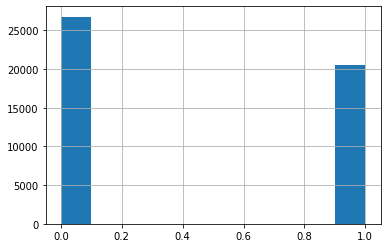

In [68]:
snorkel_labels.hist()

In [69]:
# convert pandas DF in to tf.Dataset
snorkel_train = tf.data.Dataset.from_tensor_slices((snorkel_reviews.values, 
                                            snorkel_labels.values))

In [70]:
encoded_snorkel_train = snorkel_train.map(encode_tf_fn,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

## Supervised model for snorkel data

In [109]:
# Length of the vocabulary 
vocab_size = imdb_encoder.vocab_size 

# Number of RNN units
rnn_units = 64

# Embedding size
embedding_dim = 64

#batch size
BATCH_SIZE=100 

bilstm2 = build_model_bilstm(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

bilstm2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (100, None, 64)           529024    
_________________________________________________________________
bidirectional_8 (Bidirection (100, None, 128)          66048     
_________________________________________________________________
dropout_8 (Dropout)          (100, None, 128)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (100, 128)                98816     
_________________________________________________________________
dropout_9 (Dropout)          (100, 128)                0         
_________________________________________________________________
dense_4 (Dense)              (100, 1)                  129       
Total params: 694,017
Trainable params: 694,017
Non-trainable params: 0
________________________________________________

In [110]:
bilstm2.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy', 'Precision', 'Recall'])

In [111]:
encoded_snorkel_batched = encoded_snorkel_train.batch(BATCH_SIZE, 
                                        drop_remainder=True).\
                                        shuffle(buffer_size=47200)

In [112]:
bilstm2.fit(encoded_snorkel_batched, epochs=15)

Train for 472 steps
Epoch 1/15
472/472 [==============================] - 108s 229ms/step - loss: 0.4924 - accuracy: 0.7567 - Precision: 0.7457 - Recall: 0.6663
Epoch 2/15
472/472 [==============================] - 98s 208ms/step - loss: 0.3720 - accuracy: 0.8416 - Precision: 0.8199 - Recall: 0.8135
Epoch 3/15
472/472 [==============================] - 98s 208ms/step - loss: 0.3115 - accuracy: 0.8736 - Precision: 0.8556 - Recall: 0.8523
Epoch 4/15
472/472 [==============================] - 98s 209ms/step - loss: 0.2526 - accuracy: 0.9015 - Precision: 0.8884 - Recall: 0.8840
Epoch 5/15
472/472 [==============================] - 98s 208ms/step - loss: 0.1995 - accuracy: 0.9251 - Precision: 0.9150 - Recall: 0.9121
Epoch 6/15
472/472 [==============================] - 98s 208ms/step - loss: 0.1550 - accuracy: 0.9422 - Precision: 0.9351 - Recall: 0.9314
Epoch 7/15
472/472 [==============================] - 98s 208ms/step - loss: 0.1246 - accuracy: 0.9538 - Precision: 0.9471 - Recall: 0.9462

In [113]:
bilstm2.evaluate(encoded_test.batch(BATCH_SIZE))

250/250 [==============================] - 37s 147ms/step - loss: 0.0111 - accuracy: 0.9973 - Precision: 0.9974 - Recall: 0.9972


[0.011134903659112752, 0.99732, 0.9974394, 0.9972]

In [114]:
# Massive difference in performance without shuffling
# however, model still did better than baseline without shuffling
# performance of baseline went up very slightly due to 
# shuffling though.
bilstm3 = build_model_bilstm(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

bilstm3.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy', 'Precision', 'Recall'])

encoded_snorkel_unshuff = encoded_snorkel_train.batch(BATCH_SIZE, 
                                        drop_remainder=True)

In [115]:
bilstm3.fit(encoded_snorkel_unshuff, epochs=15)

Train for 472 steps
Epoch 1/15
472/472 [==============================] - 72s 152ms/step - loss: 0.4661 - accuracy: 0.7711 - Precision: 0.7598 - Recall: 0.6908
Epoch 2/15
472/472 [==============================] - 64s 136ms/step - loss: 0.3494 - accuracy: 0.8486 - Precision: 0.8321 - Recall: 0.8155
Epoch 3/15
472/472 [==============================] - 64s 136ms/step - loss: 0.2901 - accuracy: 0.8812 - Precision: 0.8675 - Recall: 0.8570
Epoch 4/15
472/472 [==============================] - 64s 136ms/step - loss: 0.2496 - accuracy: 0.9000 - Precision: 0.8886 - Recall: 0.8798
Epoch 5/15
472/472 [==============================] - 64s 136ms/step - loss: 0.2385 - accuracy: 0.9060 - Precision: 0.8945 - Recall: 0.8880
Epoch 6/15
472/472 [==============================] - 64s 136ms/step - loss: 0.1917 - accuracy: 0.9244 - Precision: 0.9164 - Recall: 0.9087
Epoch 7/15
472/472 [==============================] - 64s 136ms/step - loss: 0.1488 - accuracy: 0.9427 - Precision: 0.9361 - Recall: 0.9316


In [116]:
bilstm3.evaluate(encoded_test.batch(BATCH_SIZE))

250/250 [==============================] - 35s 141ms/step - loss: 0.5056 - accuracy: 0.8488 - Precision: 0.8483 - Recall: 0.8496


[0.5056389166712761, 0.84884, 0.8483106, 0.8496]